2. Знакомство с новыми данными: данные о квартирах от Сбера

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sber_data = pd.read_csv('data/sber_data.csv')
#sber_data.head()

In [11]:
sber_data.shape[0]
#sber_data['sub_area'].value_counts()
#sber_data['price_doc'].max()

30471

In [12]:
#fig = plt.figure(figsize=(12, 6))
#boxplot = sns.boxplot(data=sber_data, x='price_doc', y='ecology')
#boxplot.set_title('Зависимость цены от экологии', fontsize=16)
#boxplot.set_xlabel('Цена')
#boxplot.set_ylabel('Экология')

Text(0, 0.5, 'Удаленность')

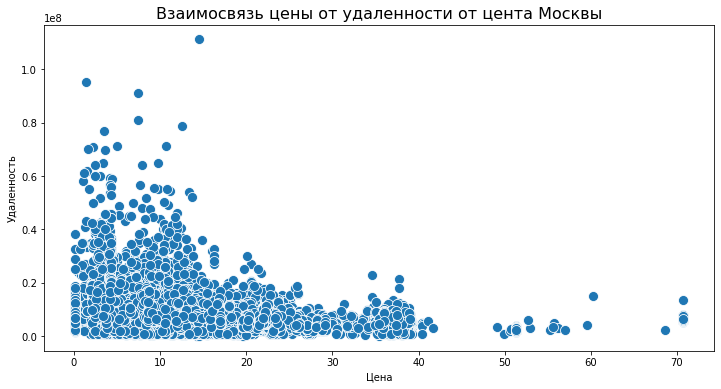

In [17]:
fig = plt.figure(figsize=(12, 6))

scatterplot = sns.scatterplot(
    data=sber_data,
    x='kremlin_km',
    y='price_doc',
    #hue='species',
    s=100,
    #size='sex',
    sizes=(50, 300)

)
scatterplot.set_title('Взаимосвязь цены от удаленности от цента Москвы', fontsize=16)
scatterplot.set_xlabel('Удаленность')
scatterplot.set_ylabel('Цена')

3. Работа с пропусками: как их обнаружить?

In [5]:
sber_data.isnull().tail()

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
30466,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30467,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30468,False,False,True,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
30469,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30470,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


СПИСОК СТОЛБЦОВ С ПРОПУСКАМИ

In [4]:
cols_null_persent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
#display(cols_with_null)

hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
metro_min_walk                0.082045
metro_km_walk                 0.082045
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
dtype: float64

СТОЛБЧАТАЯ ДИАГРАММА ПРОПУСКОВ

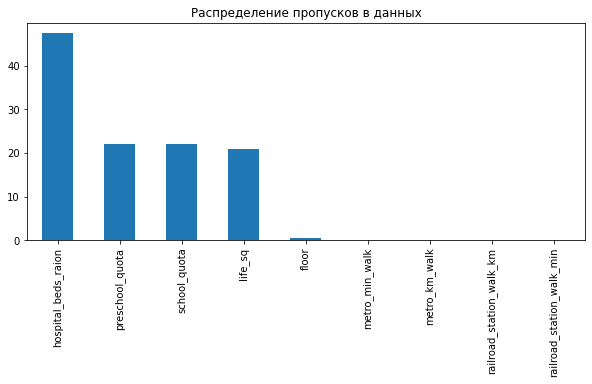

In [7]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

ТЕПЛОВАЯ КАРТА ПРОПУСКОВ 

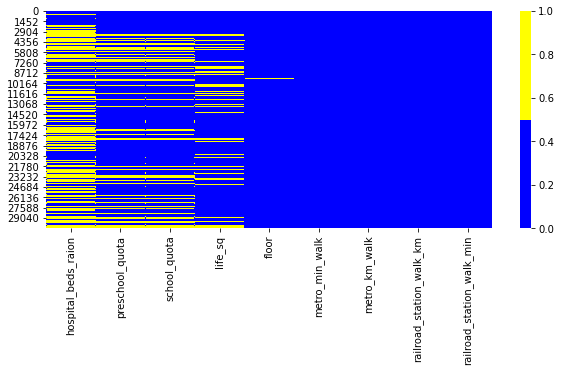

In [8]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

4. Работа с пропусками: методы обработки

ОТБРАСЫВАНИЕ ЗАПИСЕЙ И ПРИЗНАКОВ
Специалисты рекомендуют при использовании метода удаления придерживаться следующих правил: удаляйте столбец, если число пропусков в нем более 30-40 %. В остальных случаях лучше удалять записи.

In [5]:
#создаем копию исходной таблицы
drop_data = sber_data.copy()
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = drop_data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
drop_data = drop_data.dropna(how='any', thresh=thresh, axis=1)
#удаляем записи, в которых есть хотя бы 1 пропуск
drop_data = drop_data.dropna(how='any', axis=0)
#отображаем результирующую долю пропусков
drop_data.isnull().mean()


id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

In [6]:
print(drop_data.shape)

(20888, 60)


ЗАПОЛНЕНИЕ НЕДОСТАЮЩИХ ЗНАЧЕНИЙ КОНСТАНТАМИ
Чаще всего пустые места заполняют средним/медианой/модой для числовых признаков и модальным значением для категориальных признаков. 

- Для распределений, похожих на логнормальное, где пик близ нуля, а далее наблюдается постепенный спад частоты, высока вероятность наличия выбросов (о них мы поговорим чуть позже). Математически доказывается, что среднее очень чувствительно к выбросам, а вот медиана — нет. Поэтому предпочтительнее использовать медианное значение для таких признаков.
- Если признак числовой и дискретный (например, число этажей, школьная квота), то их заполнение средним/медианой является ошибочным, так как в результате может получиться нецелое число (например, 2.871 этажа). Поэтому такой признак заполняют либо модой, либо округляют до целого числа среднее/медиану.
- Категориальные признаки заполняются либо модальным значением, либо, если вы хотите оставить информацию о пропуске в данных, значением 'unknown'. На наше счастье, пропусков в категориях у нас нет.
- Иногда в данных бывает такой признак, основываясь на котором, можно заполнить пропуски в другом. Например, в наших данных есть признак full_sq (общая площадь квартиры). Давайте исходить из предположения, что, если жилая площадь (life_sq) неизвестна, то она будет равна суммарной площади!

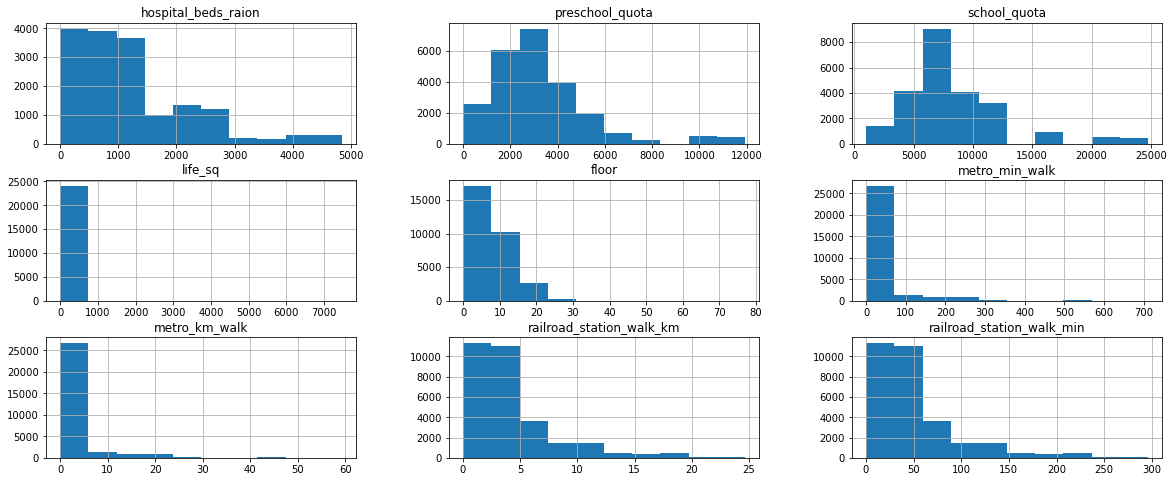

In [9]:
cols = cols_with_null.index
sber_data[cols].hist(figsize=(20, 8));

In [10]:
#создаем копию исходной таблицы
fill_data = sber_data.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'life_sq': fill_data['full_sq'],
    'metro_min_walk': fill_data['metro_min_walk'].median(),
    'metro_km_walk': fill_data['metro_km_walk'].median(),
    'railroad_station_walk_km': fill_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': fill_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': fill_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': fill_data['preschool_quota'].mode()[0],
    'school_quota': fill_data['school_quota'].mode()[0],
    'floor': fill_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

id                   0.0
full_sq              0.0
life_sq              0.0
floor                0.0
sub_area             0.0
                    ... 
theater_km           0.0
museum_km            0.0
ecology              0.0
mosque_count_1000    0.0
price_doc            0.0
Length: 61, dtype: float64

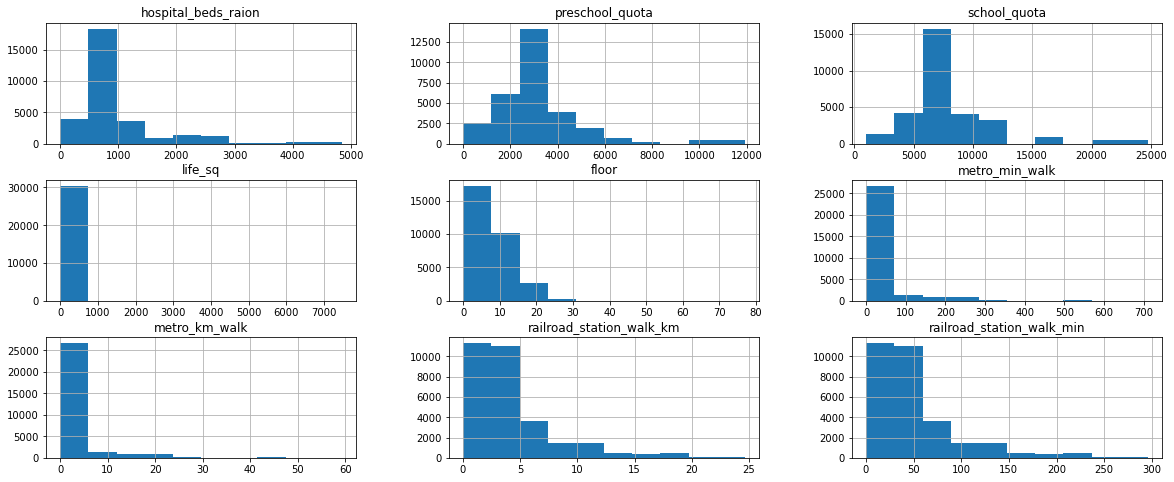

In [11]:
cols = cols_with_null.index
fill_data[cols].hist(figsize=(20, 8));

ЗАПОЛНЕНИЕ НЕДОСТАЮЩИХ ЗНАЧЕНИЙ КОНСТАНТАМИ С ДОБАВЛЕНИЕМ ИНДИКАТОРА

Метод исходит из предположения, что, если дать модели информацию о том, что в ячейке ранее была пустота, то она будет меньше доверять таким записям и меньше учитывать её в процессе обучения. Иногда такие фишки действительно работают, иногда не дают эффекта, а иногда и вовсе могут ухудшить результат обучения и затруднить процесс обучения.

In [12]:
#создаем копию исходной таблицы
indicator_data = sber_data.copy()
#в цикле пробегаемся по названиям столбцов с пропусками
for col in cols_with_null.index:
    #создаем новый признак-индикатор как col_was_null
    indicator_data[col + '_was_null'] = indicator_data[col].isnull()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски   
values = {
    'life_sq': indicator_data['full_sq'],
    'metro_min_walk': indicator_data['metro_min_walk'].median(),
    'metro_km_walk': indicator_data['metro_km_walk'].median(),
    'railroad_station_walk_km': indicator_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': indicator_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': indicator_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': indicator_data['preschool_quota'].mode()[0],
    'school_quota': indicator_data['school_quota'].mode()[0],
    'floor': indicator_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
indicator_data = indicator_data.fillna(values)
#выводим результирующую долю пропусков
indicator_data.isnull().mean()

id                                    0.0
full_sq                               0.0
life_sq                               0.0
floor                                 0.0
sub_area                              0.0
                                     ... 
floor_was_null                        0.0
metro_min_walk_was_null               0.0
metro_km_walk_was_null                0.0
railroad_station_walk_km_was_null     0.0
railroad_station_walk_min_was_null    0.0
Length: 70, dtype: float64

In [13]:
indicator_data.head()

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,price_doc,hospital_beds_raion_was_null,preschool_quota_was_null,school_quota_was_null,life_sq_was_null,floor_was_null,metro_min_walk_was_null,metro_km_walk_was_null,railroad_station_walk_km_was_null,railroad_station_walk_min_was_null
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,5850000,False,False,False,False,False,False,False,False,False
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,6000000,False,False,False,False,False,False,False,False,False
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,5700000,False,False,False,False,False,False,False,False,False
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,13100000,True,False,False,False,False,False,False,False,False
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,16331452,False,False,False,False,False,False,False,False,False


КОМБИНИРОВАНИЕ МЕТОДОВ

In [14]:
#создаём копию исходной таблицы
combine_data = sber_data.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.7
combine_data = combine_data.dropna(how='any', thresh=thresh, axis=1)

#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(how='any', thresh=m-2, axis=0)

#создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'life_sq': combine_data['full_sq'],
    'metro_min_walk': combine_data['metro_min_walk'].median(),
    'metro_km_walk': combine_data['metro_km_walk'].median(),
    'railroad_station_walk_km': combine_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': combine_data['railroad_station_walk_min'].median(),
    'preschool_quota': combine_data['preschool_quota'].mode()[0],
    'school_quota': combine_data['school_quota'].mode()[0],
    'floor': combine_data['floor'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
combine_data = combine_data.fillna(values)
#выводим результирующую долю пропусков
display(combine_data.isnull().mean())

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

ДРУГИЕ МЕТОДЫ ЗАПОЛНЕНИЯ ОТСУТСТВУЮЩИХ ЗНАЧЕНИЙ

Например, можно предсказать пропуски с помощью модели. Такой подход основывается на том, что вы считаете признак с отсутствующими значениями целевым, а остальные признаки — факторами и строите модель, предсказывающую пропуски в данных. На практике часто для заполнения «дыр» в данных используют метод ближайшего соседа (KNN) или линейную регрессию.

Ещё один подход — заполнение, основанное на группах. Можно сгруппировать данные по некоторым признакам и заполнять константой, полученной в группе. Например, в наших данных для признака жилой площади можно было бы заполнять пропуски средней площадью квартир в районе.

In [16]:
sber_data.isnull().count()

id                   30471
full_sq              30471
life_sq              30471
floor                30471
sub_area             30471
                     ...  
theater_km           30471
museum_km            30471
ecology              30471
mosque_count_1000    30471
price_doc            30471
Length: 61, dtype: int64

5. Выбросы: почему появляются и чем опасны?

ПРИЧИНЫ ПОЯВЛЕНИЯ ВЫБРОСОВ
- Ошибка ввода данных. Как и с пропусками, здесь играет роль человеческий фактор. Ввести лишний «ноль» на клавиатуре и не заметить этого — нередкий случай.
- Ошибки отбора выборки. Когда начинающие специалисты составляют обучающую выборку для моделирования, они часто допускают ошибку, не выделив в отдельную группу часть данных. Типичный пример: смешать вместе данные об уровне жизни среднего класса, опрошенного на улице, и добавить туда людей из списка Forbes.
- Преднамеренное искажение или мошенничество. Пользователи приложения часто намеренно указывают неверные данные о себе. Например, прибавляют к своему возрасту лишнюю сотню лет, создавая головную боль дата-сайентистам.

6. Методы выявления выбросов
МЕТОД РУЧНОГО ПОИСКА И ЗДРАВОГО СМЫСЛА

In [4]:
sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

In [8]:
#print(sber_data[sber_data['life_sq'] == 0].shape[0])
display(sber_data[sber_data['life_sq'] > 7000])

45


,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


In [9]:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
print(outliers.shape[0])

37


In [10]:
cleaned = sber_data.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {cleaned.shape[0]}')

Результирующее число записей: 30434


In [13]:
display(sber_data['floor'].describe())
display(sber_data[sber_data['floor']> 50])

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
23584,23587,57,33.0,77.0,Lomonosovskoe,3091.0,5,8359.0,7,1,...,0.310557,0.731683,0.489763,0.86354,0.863266,2.920671,2.757058,satisfactory,0,13700000


МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)

Алгоритм метода:
→ вычислить 25-ую и 75-ую квантили (первый и третий квартили) для признака, который мы исследуем;
→ вычислить межквартильное расстояние;
→ вычислить верхнюю и нижнюю границы Тьюки;
→ найти наблюдения, которые выходят за пределы границ.

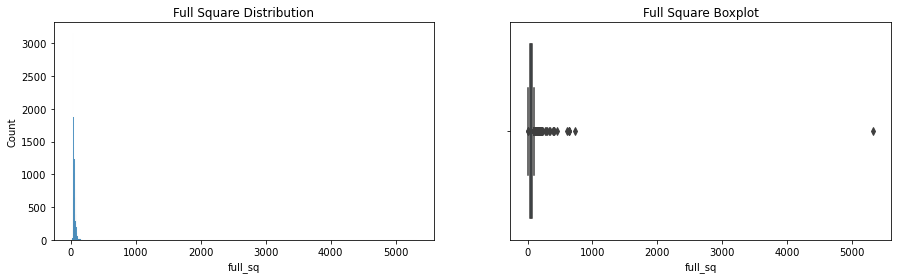

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

In [6]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [7]:
outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


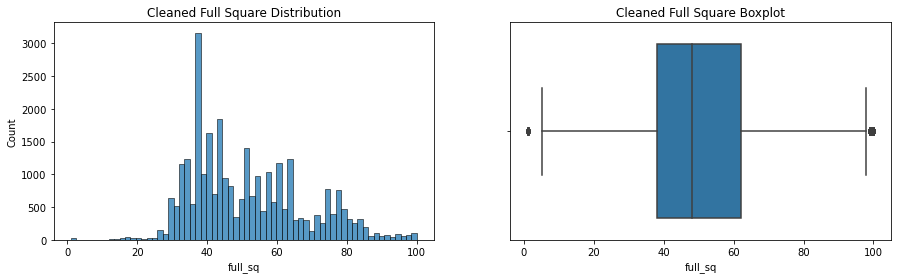

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [12]:
def outliers_iqr_mod(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    left, right = 1, 6
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [13]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq')
print(outliers.shape[0])
print(cleaned.shape[0])

59
30403


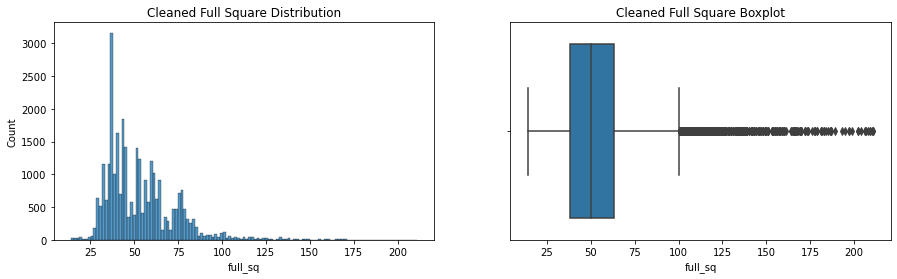

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)

Правило трёх сигм гласит: если распределение данных является нормальным, то 99,73 % лежат в интервале от (мю-3*сигма, мю+3*сигма) где  мю — математическое ожидание (для выборки это среднее значение), а  сигма — стандартное отклонение. Наблюдения, которые лежат за пределами этого интервала, будут считаться выбросами.

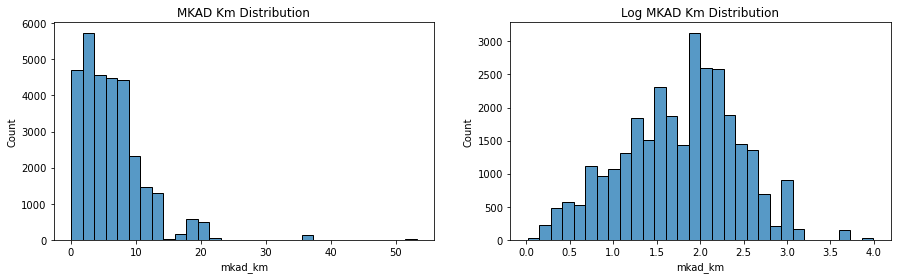

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');


Описание алгоритма метода z-отклонения:

→ вычислить математическое ожидание мю (среднее) и стандартное отклонение сигма признака икс;

→ вычислить нижнюю и верхнюю границу интервала как:
boundlower = мю-3*сигма
boundupper = мю+3*сигма

→ найти наблюдения, которые выходят за пределы границ.

In [4]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned



In [6]:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(outliers['sub_area'].unique())

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438
['Poselenie Rogovskoe' 'Poselenie Kievskij']


Выводы:
- Метод ручного поиска тяжело автоматизировать, однако вы сами организовываете проверки, следите за процессом отсеивания выбросов и руководствуетесь не только статистикой, но и здравым смыслом. К тому же из всех представленных только этот метод способен выявить логические нестыковки в данных (например, общая площадь меньше жилой или число этажей более 77 в районе, где нет таких зданий). Обычно этот метод используется в комплексе с другими, чтобы удостовериться в том, что найденные данные действительно являются выбросами, и произвести логическую очистку, на которую неспособны другие методы.
- Методы межквартильного размаха и z-отклонений довольно просты в реализации и основаны на стройной математической теории, а не на эвристиках. Но это их преимущество и недостаток. Оба метода разработаны для данных, распределённых приблизительно нормально. Проблема в том, что далеко не всё в мире имеет нормальное распределение. Необходимо внимательно «рыться» в данных, совершать дополнительные преобразования, чтобы привести их хотя бы к подобию нормального распределения, либо подбирать границы методов, чтобы учитывать особенности распределений. 

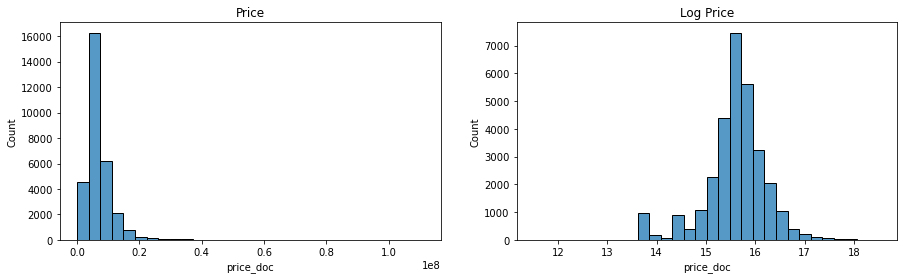

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['price_doc'], bins=30, ax=axes[0])
histplot.set_title('Price');

#гистограмма в логарифмическом масштабе
log_price_doc= np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_price_doc , bins=30, ax=axes[1])
histplot.set_title('Log Price');

In [8]:
def outliers_z_score_new(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3.7 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [9]:
outliers, cleaned = outliers_z_score_new(sber_data, 'price_doc', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 68
Результирующее число записей: 30403


In [18]:
def outliers_iqr_mod(data, feature, log_scale = False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    #left, right = 1, 6
    lower_bound = quartile_1 - (iqr * 3)
    upper_bound = quartile_3 + (iqr * 3)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [17]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 92
Результирующее число записей: 30379


7. Работа с дубликатами и неинформативными признаками

In [ ]:
ДУБЛИКАТЫ - записи, для которых значения (всех или большинства) признаков совпадают. 

In [20]:
#sber_data['id'].nunique() == sber_data.shape[0]
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 562


In [21]:
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 29909


НЕИНФОРМАТИВНЫЕ ПРИЗНАКИ - признаки, в которых большая часть строк содержит одинаковые значения (например, пол клиентов в мужском барбершопе), либо наоборот — признак, в котором для большинства записей значения уникальны (например, номер телефона клиента). 

Разберём алгоритм:

→ Создаём пустой список low_information_cols, куда будем добавлять названия признаков, которые мы посчитаем неинформативными.

→ В цикле пройдёмся по всем именам столбцов в таблице и для каждого будем совершать следующие действия:

рассчитаем top_freq — наибольшую относительную частоту с помощью метода value_counts() с параметром normalize=True. Метод вернёт долю от общих данных, которую занимает каждое уникальное значение в признаке.

Отсюда нам нужен максимум.

рассчитаем nunique_ratio — отношение числа уникальных значений в столбце к размеру всего столбца. Число уникальных значений в столбце получим с помощью метода nunique(), а размер признака — с помощью метода count(). Например, для столбца id число уникальных значений — 30471; оно же равно размеру таблицы. Поэтому результат отношения будет 1.
сравним каждое из полученных чисел с пороговым значением (у нас это 0.95) и добавим в список неинформативных признаков, если условие истинно.

In [22]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in sber_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = sber_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


In [23]:
information_sber_data = sber_data.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_sber_data.shape[1]}')

Результирующее число признаков: 55


In [ ]:
8. Закрепление знаний

In [4]:
diabetes = pd.read_csv('data/diabetes_data.csv')
#diabetes.head()

Задание 8.1. Начнём с поиска дубликатов в данных. Найдите все повторяющиеся строки в данных и удалите их. Для поиска используйте все признаки в данных. Сколько записей осталось в данных?

In [5]:
dupl_columns = list(diabetes.columns)

mask = diabetes.duplicated(subset=dupl_columns)
diabetes_duplicates = diabetes[mask]
print(f'Число найденных дубликатов: {diabetes_duplicates.shape[0]}')
diabetes = diabetes.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {diabetes.shape[0]}')

Число найденных дубликатов: 10
Результирующее число записей: 768


Задание 8.2. Далее найдите все неинформативные признаки в данных и избавьтесь от них. В качестве порога информативности возьмите 0.99: удалите все признаки, для которых 99 % значений повторяются или 99 % записей уникальны. В ответ запишите имена признаков, которые вы нашли (без кавычек).

In [6]:
low_information_cols = [] 

for col in diabetes.columns:
    top_freq = diabetes[col].value_counts(normalize=True).max()
    nunique_ratio = diabetes[col].nunique() / diabetes[col].count()
    if top_freq > 0.99:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 3)}% одинаковых значений')
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 3)}% уникальных значений')

Gender: 100.0% одинаковых значений


In [7]:
diabetes = diabetes.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {diabetes.shape[1]}')

Результирующее число признаков: 9


Задание 8.3. Замените все записи, равные 0, в столбцах Glucose, BloodPressure, SkinThickness, Insulin и BMI на символ пропуска. Его вы можете взять из библиотеки numpy: np.nan. Какая доля пропусков содержится в столбце Insulin? Ответ округлите до сотых.

In [8]:
def replace_null(x):
    return np.nan if x == 0 else x

diabetes['Glucose'] = diabetes['Glucose'].apply(replace_null)
diabetes['BloodPressure'] = diabetes['BloodPressure'].apply(replace_null)
diabetes['SkinThickness'] = diabetes['SkinThickness'].apply(replace_null)
diabetes['Insulin'] = diabetes['Insulin'].apply(replace_null)
diabetes['BMI'] = diabetes['BMI'].apply(replace_null)


In [9]:
round(diabetes['Insulin'].isna().mean(), 2)

0.49

Задание 8.4. Удалите из данных признаки, где число пропусков составляет более 30 %. Сколько признаков осталось в ваших данных?

In [10]:
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = diabetes.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
diabetes = diabetes.dropna(how='any', thresh=thresh, axis=1)

In [11]:
diabetes.shape

(768, 8)

Задание 8.5. Удалите из данных только те строки, в которых содержится минимум два пропуска одновременно. Чему равно результирующее число записей в таблице?

In [12]:
diabetes_df = diabetes.copy()
m = diabetes_df.shape[1]
diabetes_df = diabetes_df.dropna(thresh = m-2, axis=0)

diabetes_df.shape

(761, 8)

Задание 8.6. В оставшихся записях замените пропуски на медиану. Чему равно среднее значение в столбце SkinThickness? Ответ округлите до десятых.

In [13]:
values = {
    'Pregnancies': diabetes_df['Pregnancies'].median(),
    'Glucose': diabetes_df['Glucose'].median(),
    'BloodPressure': diabetes_df['BloodPressure'].median(),
    'SkinThickness': diabetes_df['SkinThickness'].median(),
    'BMI': diabetes_df['BMI'].median(),
    'DiabetesPedigreeFunction': diabetes_df['DiabetesPedigreeFunction'].median(),
    'Age': diabetes_df['Age'].median(),
    'Outcome': diabetes_df['Outcome'].median(),
}
#заполняем пропуски в соответствии с заявленным словарем
diabetes_df = diabetes_df.fillna(values)
#выводим результирующую долю пропусков


In [14]:
round(diabetes_df['SkinThickness'].mean(), 1)

29.1

Задание 8.7. Сколько выбросов найдёт классический метод межквартильного размаха в признаке SkinThickness?

In [15]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(diabetes_df, 'SkinThickness')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Задание 8.8. Сколько выбросов найдёт классический метод z-отклонения в признаке SkinThickness?

In [21]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(diabetes_df, 'SkinThickness', log_scale=False)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 4
Результирующее число записей: 757


Задание 8.9. На приведённой гистограмме показано распределение признака DiabetesPedigreeFunction. Такой вид распределения очень похож на логнормальный, и он заставляет задуматься о логарифмировании признака. Найдите сначала число выбросов в признаке DiabetesPedigreeFunction с помощью классического метода межквартильного размаха.


In [22]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(diabetes_df, 'DiabetesPedigreeFunction')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

Число выбросов по методу Тьюки: 29


Затем найдите число выбросов в этом же признаке в логарифмическом масштабе (при логарифмировании единицу прибавлять не нужно!). Какова разница между двумя этими числами (вычтите из первого второе)?

In [25]:
def outliers_iqr_mod(data, feature, log_scale = False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(diabetes_df, 'DiabetesPedigreeFunction', log_scale = True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

Число выбросов по методу Тьюки: 29
